**Linear regression**

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#PyMC2" data-toc-modified-id="PyMC2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PyMC2</a></div><div class="lev1 toc-item"><a href="#PyMC3" data-toc-modified-id="PyMC3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PyMC3</a></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm2
import pymc3 as pm3
import scipy.stats as stats
import pprint as pp

np.random.seed(1234)
plt.style.use('ggplot')

# plots don't show on notebook unless use this
%matplotlib inline

In [2]:
# generate data

# True parameter values
alpha = 1
sigma = 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
vx1 = np.random.randn(size)
vx2 = np.random.randn(size) * 0.2

# Simulate outcome variable
vy = alpha + beta[0]*vx1 + beta[1]*vx2 + np.random.randn(size)*sigma

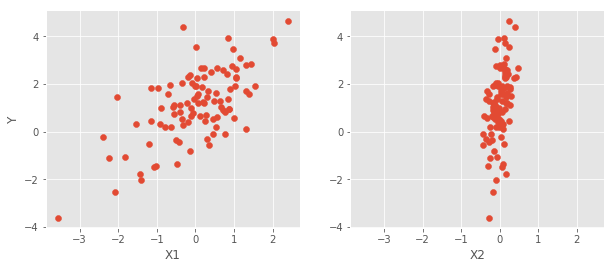

In [3]:
# plot data

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(vx1, vy)
axes[1].scatter(vx2, vy)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

# PyMC2

In [4]:
# define model
alpha_ = pm2.Normal('alpha', mu=0, tau=.01)
beta0_ = pm2.Normal('beta0', mu=0, tau=.01)
beta1_ = pm2.Normal('beta1', mu=0, tau=.01)
# beta_ = np.array([beta0_, beta1_])
sigma_ = pm2.HalfNormal('sigma', tau=1)

@pm2.deterministic
def tau_(sigma=sigma_):
    return 1/pow(sigma, 2)

@pm2.deterministic
def mu_(alpha=alpha_, beta0=beta0_, beta1=beta1_, x1=vx1, x2=vx2):
    return alpha + beta0*x1 + beta1*x2

y_ = pm2.Normal('y', mu=mu_, tau= tau_, value=vy, observed=True)
mod = pm2.Model([alpha_, beta0_, beta1_, sigma_])

In [5]:
# map estimates of variables, could be used as starting values for sampler
mapper = pm2.MAP(mod)
mapper.fit()
for x in mod.variables:
    print(x, "=",  x.value)

beta1 = 3.1268266096312924
sigma = 0.9256598478615586
beta0 = 0.9098723182112459
alpha = 1.160106676678806


In [6]:
# sample model
sampler = pm2.MCMC(mod)
sampler.sample(iter=11000, burn=10000)

 [-----------------100%-----------------] 11000 of 11000 complete in 5.9 sec

Plotting beta1
Plotting beta0
Plotting sigma
Plotting alpha


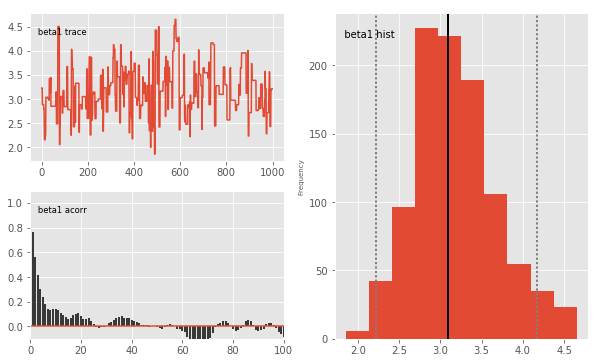

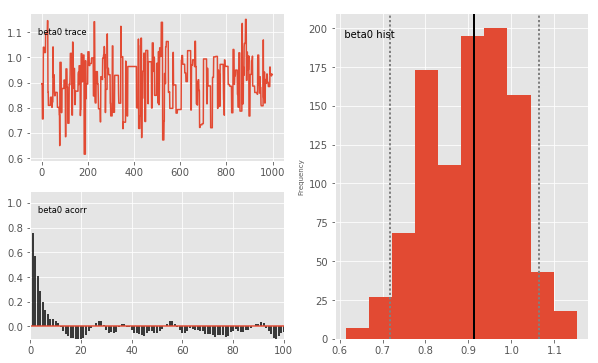

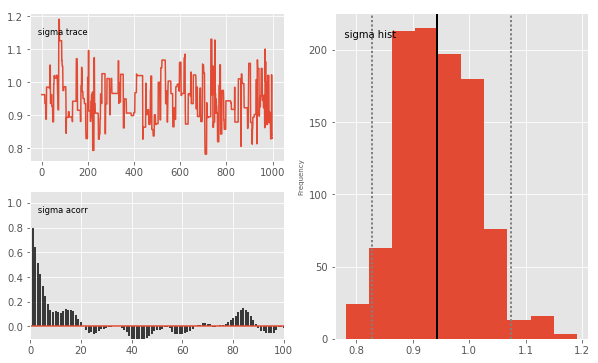

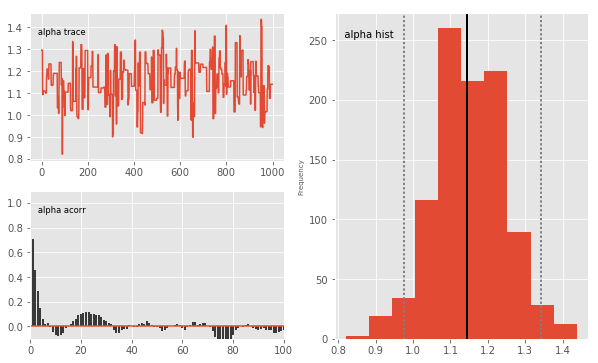

In [7]:
# analysis of samples
pm2.Matplot.plot(sampler, path="pymc2_plots");

In [8]:
for x in mod.variables:
    x.summary()


beta1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	3.164            0.508            0.035            [ 2.22   4.164]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	2.281            2.82            3.098          3.463         4.279
	

sigma:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.948            0.069            0.005            [ 0.827  1.073]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.827            0.896           0.943          1.0           1.073
	

beta0:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [9]:
%%bash
rm -rf pymc2_plots/

# PyMC3

In [10]:
# define model
basic_model = pm3.Model()

with basic_model:
    alpha_ = pm3.Normal('alpha', mu=0, sd=10)
    beta_ = pm3.Normal('beta', mu=0, sd=10, shape=2)
    sigma_ = pm3.HalfNormal('sigma', sd=1)
    mu_ = alpha_ + beta_[0]*vx1 + beta_[1]*vx2
    y_ = pm3.Normal('Y_obs', mu=mu_, sd=sigma_, observed=vy)

In [11]:
# map estimates
map_vals = pm3.find_MAP(model=basic_model)
pp.pprint(map_vals)

Optimization terminated successfully.
         Current function value: 145.050775
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21
{'alpha': array(1.1601588087666992),
 'beta': array([ 0.90985491,  3.12776093]),
 'sigma_log_': array(-0.07230886576103965)}


In [12]:
# sample model
from pymc3 import NUTS, sample
from scipy import optimize

with basic_model:
    # draw 2000 posterior samples
    trace = sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -149.54: 100%|██████████| 200000/200000 [00:25<00:00, 7949.11it/s] 
Finished [100%]: Average ELBO = -149.52
100%|██████████| 2000/2000 [00:03<00:00, 581.35it/s]


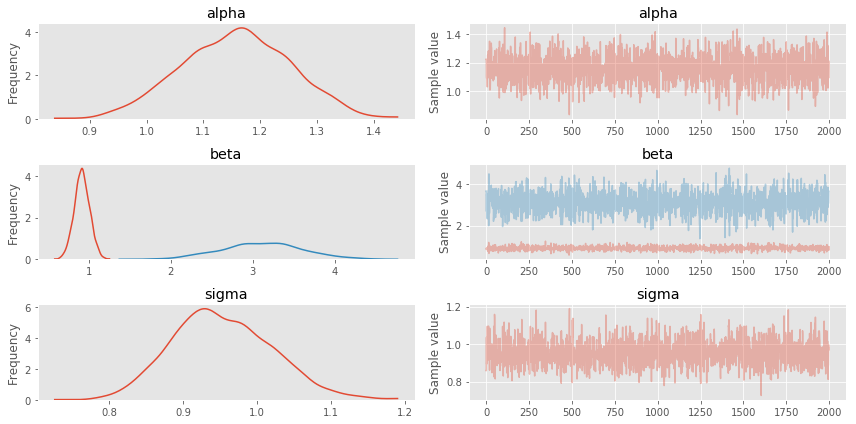

In [13]:
# analysis of samples
pm3.traceplot(trace);

In [14]:
pm3.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.158            0.095            0.002            [0.973, 1.337]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.973          1.092          1.161          1.225          1.337


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.915            0.094            0.002            [0.736, 1.105]
  3.114            0.497            0.013            [2.121, 4.028]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.732          0.854          0.915          0.977          1.101
  2.161          2.795          3.123   